# Exempel på analys av data från laboration
Notera att detta exempel är mer omfattande än vad som begärs i laborationen.

Reaktantlösningar:

I)
3 mM KSCN
33 mM NaClO4
50 mM HClO4

II)
6 mM Fe(ClO4)3
50 mM HClO4

a, b, c, d:
+0, +20, +40, +60 mM NaClO4 till båda lösningarna

In [1]:
from __future__ import division
import os
import collections

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import sympy
from IPython.display import display

from aqchem.kinetics.integrated import pseudo_irrev, pseudo_rev, binary_irrev, binary_rev

sympy.init_printing()
%matplotlib inline

Följande information är från labbpek och våra uppmäta data från labb:

In [2]:
deciCs = 165, 185, 205, 225, 245  #  * degC/10
ntemps = len(deciCs)
tempKs = 0.1*np.array(deciCs) + 273.15  # * K
Itoks = b'abcd'
ntoks = len(Itoks)
limiting_C = 3e-3/2  # * M, faktor 2 spädning vid blanding
excess_C = 6e-3/2    # *M , faktor 2 spädning vid blanding
Ibase = 86e-3        # *M,  jonstyrka
beta = 10**2.065     # stabilitetskonstant
eps_l = 5148         # extinktionskoefficient * kyvettlängd
nreplicates = 7      # antal replikat
nfuncs = 4           # antal funktionsuttryck
nparams = 3          # antal parameterar: kf, P0, t0
ionic_strengths = Ibase + 1e-3*np.array([0, 20, 40, 60])

Analytiska uttryck är redan fördefinierade:

Pseudo first order irreversible


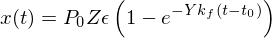

Pseudo first order reversible


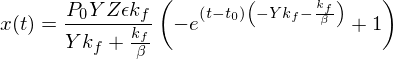

Second order irreversible


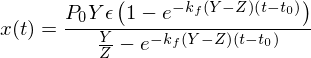

Second order reversible


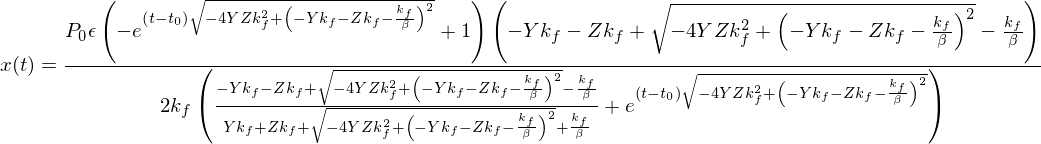

In [3]:
def partial(fun, *args, **kwargs):
    """ functools.partial does not seem to preserve name attribute """
    from functools import partial as _partial
    f = _partial(fun, *args, **kwargs)
    f.name = fun.name
    return f

funcs = collections.OrderedDict([
    ('pseudo_irrev', partial(pseudo_irrev, excess_C=excess_C, limiting_C=limiting_C, eps_l=eps_l)),
    ('pseudo_rev', partial(pseudo_rev, excess_C=excess_C, limiting_C=limiting_C, eps_l=eps_l, beta=beta)),
    ('binary_irrev', partial(binary_irrev, excess_C=excess_C, limiting_C=limiting_C, eps_l=eps_l)),
    ('binary_rev', partial(binary_rev, excess_C=excess_C, limiting_C=limiting_C, eps_l=eps_l, beta=beta))
])
t, kf, P0, t0, excess_C, limiting_C, eps_l, beta = sympy.symbols(
    't k_f P0 t0 Y Z epsilon beta', positive=True)
for func in (pseudo_irrev, pseudo_rev, binary_irrev, binary_rev):
    args = t, kf, P0, t0, excess_C, limiting_C, eps_l
    kwargs = {'exp': sympy.exp}
    if func in (pseudo_rev, binary_rev):
        args += (beta,)
    if func is binary_rev:
        kwargs['one'] = sympy.S(1)
    print(func.name)
    display(sympy.Eq(sympy.Function('x')(t), func(*args, **kwargs)))

In [4]:
help(pseudo_irrev)  # notera ordningen: kf, P0, t0  => popt[0], popt[1], popt[2]

Help on function pseudo_irrev in module aqchem.kinetics.integrated:

pseudo_irrev(t, kf, P0, t0, excess_C, limiting_C, eps_l, exp=None)



Rådata från experimenten ligger som textfiler

In [5]:
!echo "$ ls spec_data2/*"
!ls spec_data2/*
!echo "\n\n$ ls spec_data2/a/16.5"
!ls spec_data2/a/16.5
!echo "\n\n$ head -n 2 spec_data2/a/16.5/1.txt"
!head -n 2 spec_data2/a/16.5/1.txt

$ ls spec_data2/*
spec_data2/a:
16.5  18.5  20.5  22.5	24.5

spec_data2/b:
16.5  18.5  20.5  22.5	24.5

spec_data2/c:
16.5  18.5  20.5  22.5	24.5

spec_data2/d:
16.5  18.5  20.5  22.5	24.5


$ ls spec_data2/a/16.5
1.txt  2.txt  3.txt  4.txt  5.txt  6.txt  7.txt


$ head -n 2 spec_data2/a/16.5/1.txt
 0,0000	 0,0174
13,0000	 0,0335


Kommatecken behöver konverteras till punkter (svensk vs. engelsk notation)

In [6]:
data = {}  # data files are of different lenght, hence not possible to put in one array
def commadecimal2float(s):
    return float(s.replace(',', '.'))
for Itok in Itoks:
    for deciC in deciCs:
        for idx in range(nreplicates):
            arr = np.loadtxt(
                os.path.join('spec_data2', Itok, str(deciC//10) + '.' + str(deciC % 10) + '/' + str(idx+1) + '.txt'),
                converters=dict(zip(range(2), [commadecimal2float]*2)))
            arr[:, 0] *= 1e-3  # ms -> s
            data[Itok, deciC, idx] = arr
len(data.keys())
data['a', 165, 0].shape, data['a', 165, 0].dtype, data['a', 165, 0][-1, :]

((282, 2), dtype('float64'), array([ 3.01  ,  0.3548]))

Vi genomför ni ickelinjär kurvanpassning på var och en av data filerna med de 4 funktions uttrycken
Opimerade parametrar hamnar i ``all_popt`` och uppskattade kovariansmatriser i ``all_pcov``.

In [7]:
all_popt = np.empty((ntoks, ntemps, nfuncs, nreplicates, nparams))
all_pcov = np.empty((ntoks, ntemps, nfuncs, nreplicates, nparams, nparams))
fitparams = collections.defaultdict(dict)
for idxI, Itok in enumerate(Itoks):
    for idxT, deciC in enumerate(deciCs):
        for idxR in range(nreplicates):
            arr = data[Itok, deciC, idxR]
            for idxF, func in enumerate(funcs.values()):
                popt, pcov = curve_fit(func, arr[:, 0], arr[:, 1], [250, 0.1, -0.05])
                all_popt[idxI, idxT, idxF, idxR, :] = popt
                all_pcov[idxI, idxT, idxF, idxR, :, :] = pcov

In [8]:
def plot_conditions(idxT, idxI, funckey, colors='k'):
    deciC = deciCs[idxT]
    Itok = Itoks[idxI]
    plt.title("{} {}".format(deciC, Itok))
    for idxR in range(nreplicates):
        c = colors[idxR % len(colors)]
        tpl = Itok, deciC, idxR
        arr = data[tpl]
        plt.plot(arr[:, 0], arr[:, 1], alpha=0.3, c=c)
        
        popt = all_popt[idxI, idxT, funcs.keys().index(funckey), idxR, :]
        pcov = all_pcov[idxI, idxT, funcs.keys().index(funckey), idxR, :, :]
        fmtstr = '$k_f = {0:.1f} \pm {1:.1f}$ $M^{{-1}} s^{{-1}}$'
        lbl = fmtstr.format(popt[0], pcov[0, 0]**0.5)
        plt.plot(arr[:, 0], funcs[funckey](arr[:, 0], *popt), alpha=0.6, label=lbl, c=c)
        
    plt.legend(loc='best')
    plt.ylim((0, 0.40))
    
def plot_fits(funckey):
    plt.figure(figsize=(20,25))
    for idxT, deciC in enumerate(deciCs):
        for idxI, Itok in enumerate(Itoks):
            plt.subplot(5, 4, 4*idxT + idxI + 1)
            plot_conditions(idxT, idxI, funckey)

För lägst temperatur och lägst jonstyrka ser våra passningar ut enligt nedan:

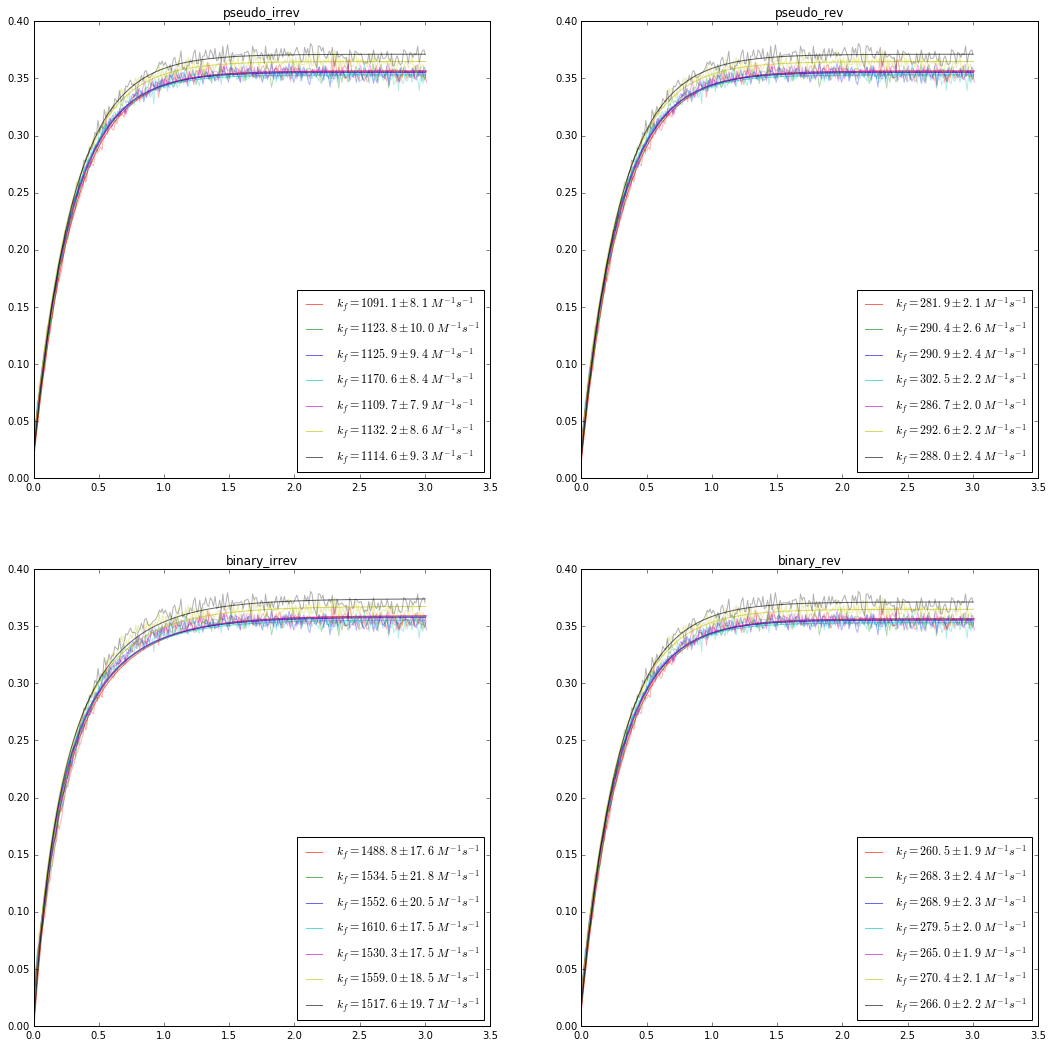

In [9]:
plt.figure(figsize=(18,18))
for idx in range(nfuncs):
    plt.subplot(2, 2, idx+1)
    funckey = funcs.keys()[idx]
    plot_conditions(0, 0, funckey, 'rgbcmyk')
    plt.title(funckey)

Nu plottar vi alla data för de pseudo första och andra ordningens reaktion (irreversibelt fall, reversibilitet ändrar inte funktionsformen, endast tolkningen av parametrarna)

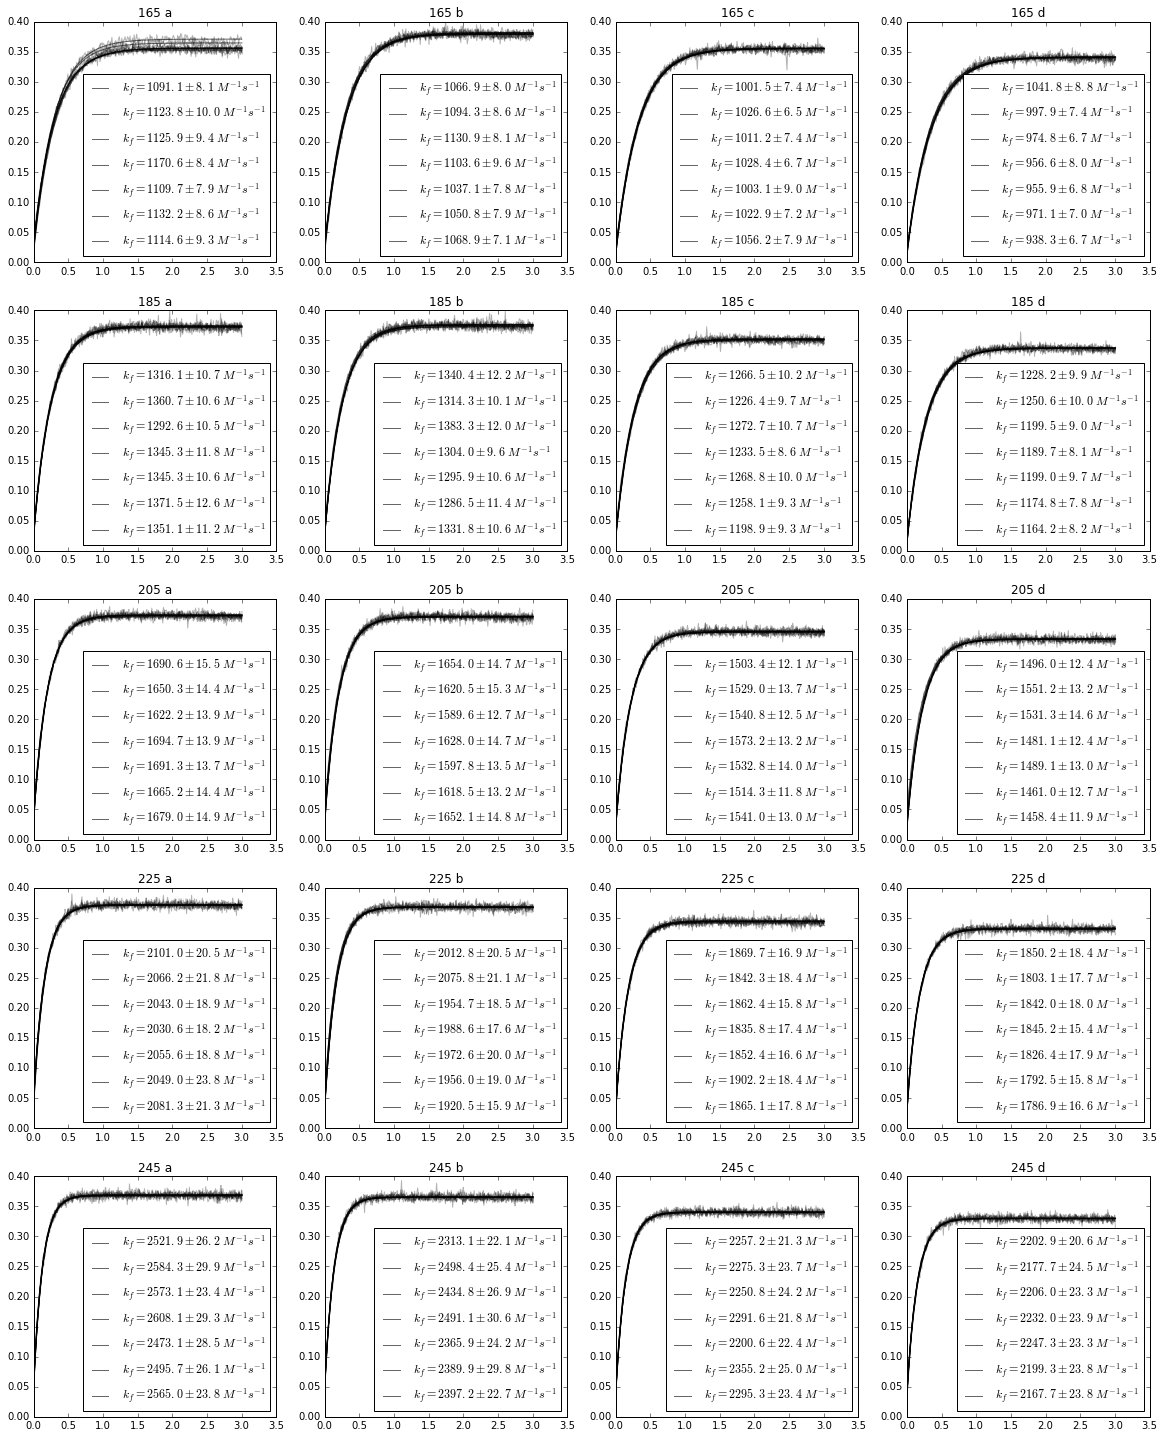

In [10]:
plot_fits('pseudo_irrev')

In [11]:
#plot_fits('pseudo_rev')

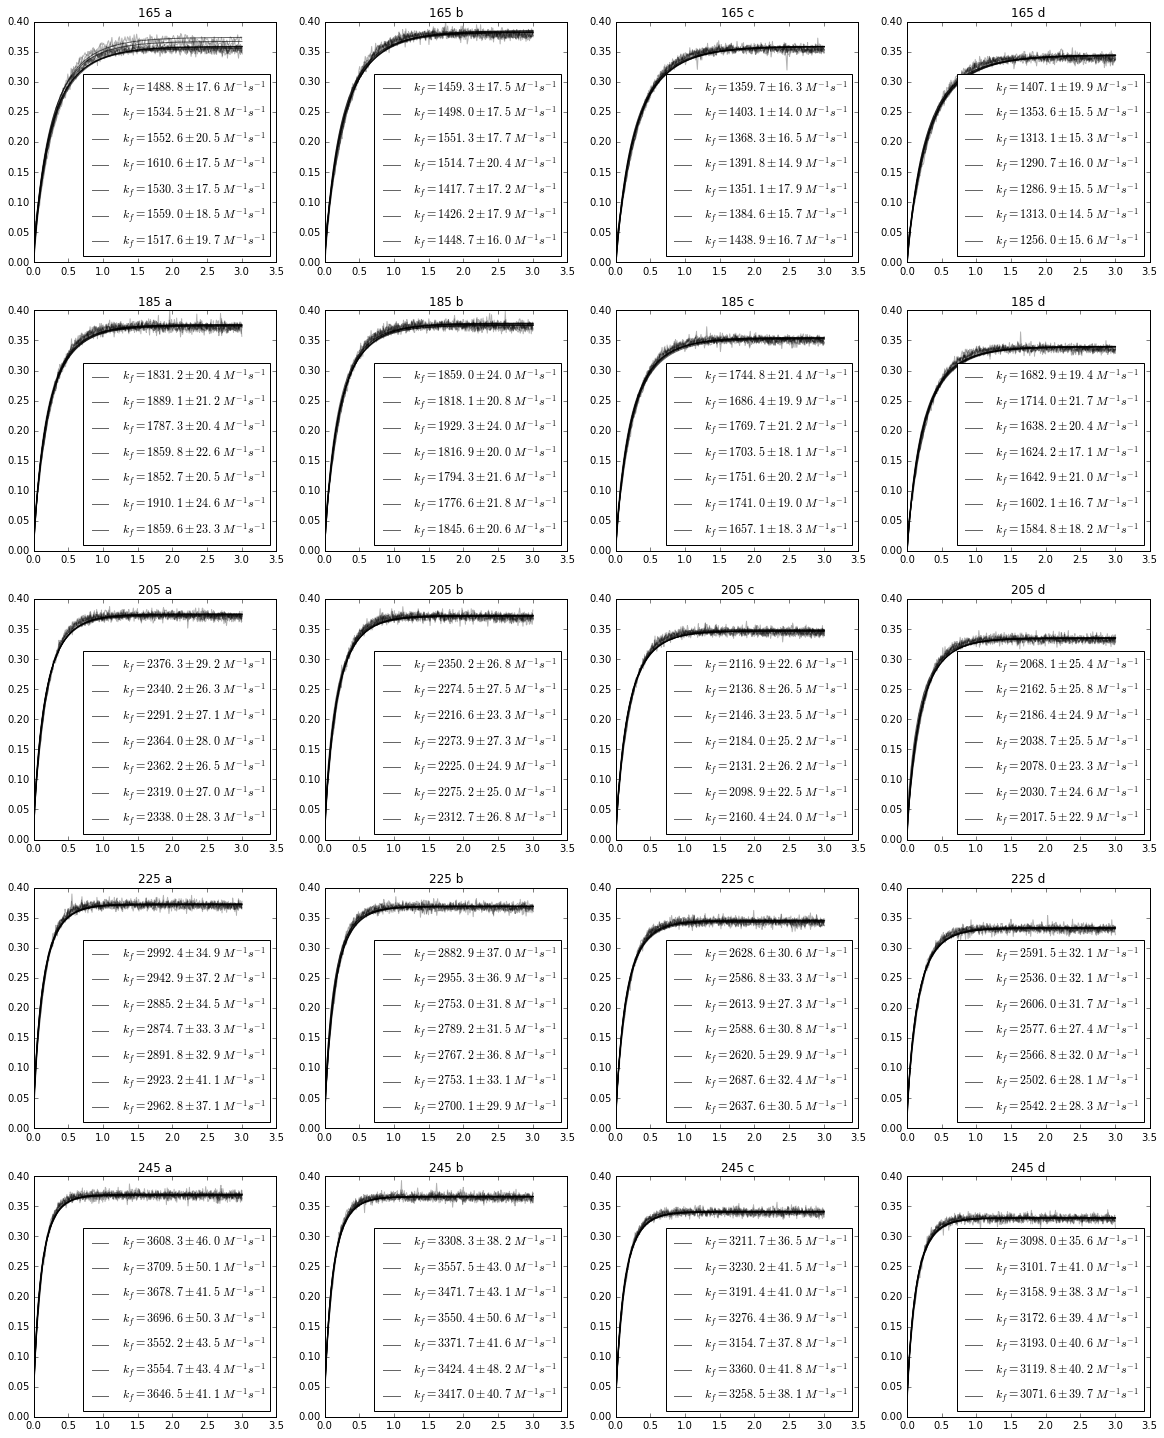

In [12]:
plot_fits('binary_irrev')

In [13]:
#plot_fits('binary_rev')

Vi har nu optimerade parametrar (med respektive kovariansmatriser) för alla enskila försök. Nu pool:ar vi dessa och analyserar dem statistiskt.

In [14]:
# jonstyrka, temperatur, uttryck, parameter, [medel/varians]
pooled_fits = np.empty((ntoks, ntemps, nfuncs, nparams, 2))
rel_err_k = collections.defaultdict(float)
for idxT, deciC in enumerate(deciCs):
    for idxI, Itok in enumerate(Itoks):
        for idxF, funckey in enumerate(funcs):
            weighted_sum = np.zeros(nparams)
            sum_of_weights = np.zeros(nparams)
            for idxR in range(nreplicates):
                popt = all_popt[idxI, idxT, idxF, idxR, :]
                pcov = all_pcov[idxI, idxT, idxF, idxR, :, :]
                for idxP in range(nparams):
                    weighted_sum[idxP] += popt[idxP]/pcov[idxP, idxP]
                    sum_of_weights[idxP] += 1/pcov[idxP, idxP]
            mean = weighted_sum/sum_of_weights
            var = np.zeros(nparams)
            for idx in range(nreplicates):
                popt = all_popt[idxI, idxT, idxF, idxR, :]
                pcov = all_pcov[idxI, idxT, idxF, idxR, :, :]
                for idxP in range(nparams):
                    var += (mean[idxP] - popt[idxP])**2/pcov[idxP, idxP]
            var /= (nreplicates-1)*sum_of_weights
            pooled_fits[idxI, idxT, idxF, :, 0] = mean
            pooled_fits[idxI, idxT, idxF, :, 1] = var
            #pooled_fits[Itok, deciC, funckey] = (kmean, kvar**0.5)
            rel_err_k[funckey] += var[0]**0.5/mean[0]
pooled_fits
rel_err_k.items()

[('binary_irrev', 0.39273314744992616),
 ('binary_rev', 0.38208842424778078),
 ('pseudo_rev', 0.38195636777495995),
 ('pseudo_irrev', 0.3819561717336234)]

In [15]:
pooled_fits[0, 0, 0, 0, 0], pooled_fits[0, 0, 0, 0, 1]**0.5, all_popt[0, 0, 0, 0, 0]

In [16]:
def kf_val(funckey):
    return pooled_fits[:, :, funcs.keys().index(funckey), 0, :]
kf_val('binary_rev')

array([[[ 268.22576798,  840.47390038],
        [ 319.6716533 ,   14.63640812],
        [ 398.97464687,   44.29598029],
        [ 492.22168415,   50.0397381 ],
        [ 608.63479192,   84.4194799 ]],

       [[ 257.00501577,   29.17734715],
        [ 315.15144795,   33.42946112],
        [ 387.19679891,   18.04552106],
        [ 472.26926519,   70.3096203 ],
        [ 574.76216257,   55.30360557]],

       [[ 243.96328925,    9.68630903],
        [ 297.13782383,   37.28492359],
        [ 366.01757647,   14.77681742],
        [ 444.70068481,    3.58126471],
        [ 543.3354262 ,   53.30120945]],

       [[ 232.07235845,   16.20640107],
        [ 285.54990493,   12.91579205],
        [ 356.5511031 ,   33.02454525],
        [ 434.84861966,   69.70199195],
        [ 527.04585889,   18.26146994]]])

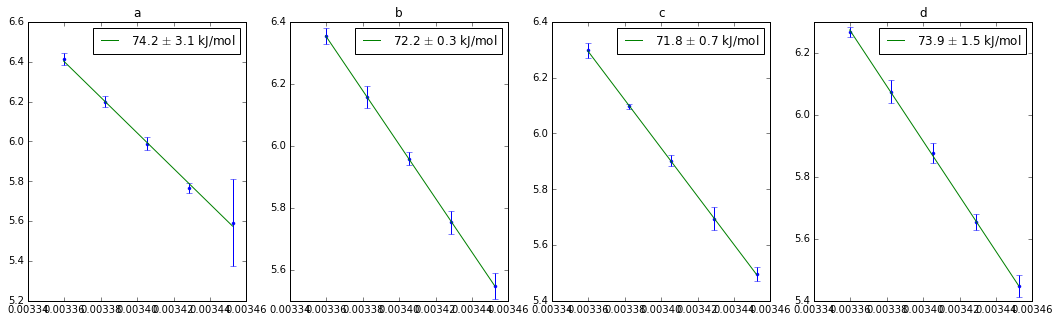

In [17]:
plt.figure(figsize=(18,5))
arrhenius_params = np.empty((ntoks, 2, 2))
logkf, delta_logkf = np.empty((ntoks, ntemps)), np.empty((ntoks, ntemps))
for Iidx, Itok in enumerate(Itoks):
    logkf[Iidx, :] = np.log(kf_val('binary_rev')[Iidx, :, 0])
    kf_u = kf_val('binary_rev')[Iidx, :, 0] + kf_val('binary_rev')[Iidx, :, 1]**0.5
    kf_l = kf_val('binary_rev')[Iidx, :, 0] - kf_val('binary_rev')[Iidx, :, 1]**0.5
    delta_logkf[Iidx, :] = np.log(kf_u) - np.log(kf_l)
    
    plt.subplot(1, 4, Iidx + 1)
    lin_opt, lin_cov = np.polyfit(1/tempKs, logkf[Iidx, :], 1, cov=True)
    arrhenius_params[Iidx, :, 0] = lin_opt[:]
    for i in range(2):
        arrhenius_params[Iidx, i, 1] = lin_cov[i, i]
    plt.errorbar(1/tempKs, logkf[Iidx, :], delta_logkf[Iidx, :], marker='.', ls='None')
    lbl = '{0:.1f} $\pm$ {1:.1f} kJ/mol'.format(lin_opt[0]*-8.314511e-3, lin_cov[0,0]**0.5 * 8.314511e-3)
    plt.plot(1/tempKs, np.polyval(lin_opt, 1/tempKs), label=lbl)
    plt.title(Itok)
    plt.legend(loc='best')

Hur ser medelvärdet (för de olika jonstyrkorna) ut för våra arrhenius parametrar?

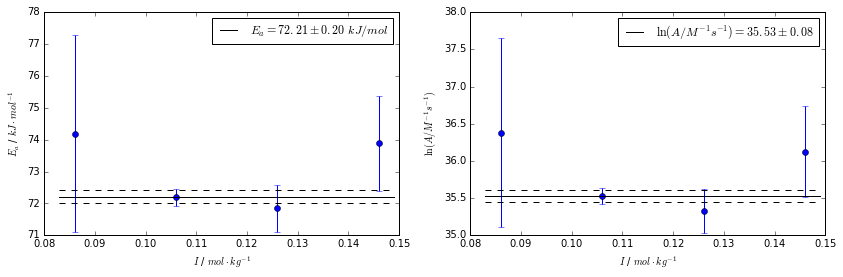

In [18]:
def weighted_average(val, var):
    w = 1/var
    wsum = np.sum(w)
    avgw = np.dot(val, w)/wsum
    denom = (len(val)-1)*wsum
    sigma2 = np.dot(w, (val-avgw)**2)/denom
    return avgw, sigma2

from math import exp
Ea, Ea_s2 = weighted_average(arrhenius_params[:, 0, 0], arrhenius_params[:, 0, 1])
Ea = -8.314511*Ea
dEa = 8.314511*Ea_s2**0.5
lnA, lnA_s2 = weighted_average(arrhenius_params[:, 1, 0], arrhenius_params[:, 1, 1])
dlnA = lnA_s2**0.5
A = exp(lnA)
dA = (exp(lnA+lnA_s2**0.5) - exp(lnA-lnA_s2**0.5))/2
Ea, dEa, A, dA


Ilim = ionic_strengths[0], ionic_strengths[-1]
Ispan = Ilim[1] - Ilim[0]
Ilim = Ilim[0] - 0.05*Ispan, Ilim[1] + 0.05*Ispan

plt.figure(figsize=(14,4))
plt.subplot(1, 2, 1)
plt.errorbar(ionic_strengths,
             1e-3*-8.314511*arrhenius_params[:, 0, 0],
             1e-3*8.314511*arrhenius_params[:, 0, 1]**0.5,
             ls='None', marker='o')
fmtstr = '$E_a={:.2f} \pm {:.2f}$ $kJ/mol$'
lbl = fmtstr.format(1e-3*Ea, 1e-3*dEa)
plt.plot(Ilim, [1e-3*Ea]*2, 'k-', label=lbl)
plt.plot(Ilim, [1e-3*(Ea-dEa)]*2, 'k--')
plt.plot(Ilim, [1e-3*(Ea+dEa)]*2, 'k--')
plt.xlabel(r'$I$ / $mol \cdot kg^{-1}$')
plt.ylabel(r'$E_a$ / $kJ \cdot mol^{-1}$')
_ = plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(ionic_strengths,
             arrhenius_params[:, 1, 0],
             arrhenius_params[:, 1, 1]**0.5,
             ls='None', marker='o')
fmtstr = '$\ln(A/M^{{-1}}s^{{-1}})={:.2f} \pm {:.2f}$'
lbl = fmtstr.format(lnA, dlnA)
plt.plot(Ilim, [lnA]*2, 'k-', label=lbl)
plt.plot(Ilim, [lnA-dlnA]*2, 'k--')
plt.plot(Ilim, [lnA+dlnA]*2, 'k--')
plt.xlabel(r'$I$ / $mol \cdot kg^{-1}$')
plt.ylabel(r'$\ln(A/M^{-1}s^{-1})$')
_ = plt.legend(loc='best')

Vi ser ingen trend alls, är det förväntat?

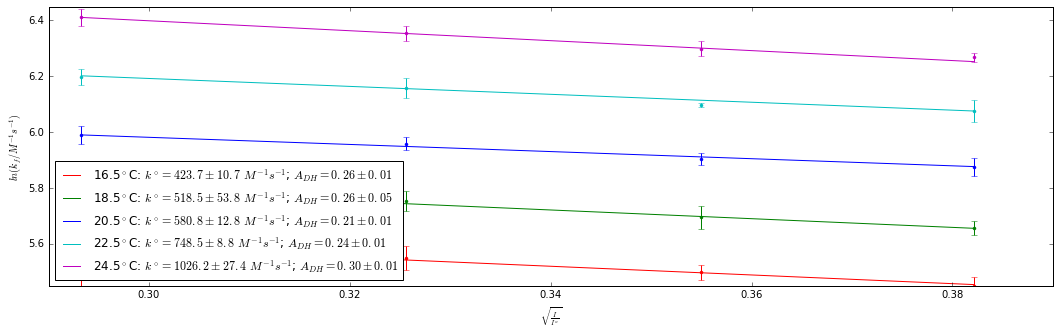

In [19]:
plt.figure(figsize=(18,5))
sqrtI = np.sqrt(ionic_strengths)
logk0 = np.empty((len(deciCs), 2))
k0 = np.empty((len(deciCs), 2))
A_DH = np.empty((len(deciCs), 2))
color = 'rgbcmyk'
for Tidx, deciC in enumerate(deciCs):
    #plt.subplot(1, 5, Tidx + 1)
    popt, pcov = curve_fit(lambda x, k, m: x*k + m, sqrtI, logkf[:, Tidx], [0, 0], sigma=delta_logkf[:, Tidx]**-2)
    #popt, pcov = np.polyfit(sqrtI, logkf[:, Tidx], 1, w=dlogkf[:, Tidx]**-2, cov=True)
    logk0[Tidx, :] = popt[1], pcov[1, 1]**0.5
    k0[Tidx, 0] = np.exp(popt[1])
    k0[Tidx, 1] = (np.exp(popt[1] + pcov[1, 1]**0.5) - np.exp(popt[1] - pcov[1, 1]**0.5))/2
    A_DH[Tidx, :] = popt[0]/-6, pcov[0, 0]**0.5/6
    c = color[Tidx % len(color)]
    plt.errorbar(sqrtI, logkf[:, Tidx], delta_logkf[:, Tidx], marker='.', ls='None', c=c)
    lbl = r'{}$^\circ$C: '.format(deciC/10.0)
    lbl += r'$k^\circ={0:.1f} \pm {1:.1f}$ $M^{{-1}}s^{{-1}}$'.format(k0[Tidx, 0], k0[Tidx, 1])
    lbl += r'; $A_{{DH}}={0:.2f} \pm {1:.2f}$'.format(A_DH[Tidx, 0], A_DH[Tidx, 1])
    plt.plot(sqrtI, np.polyval(popt, sqrtI), label=lbl, c=c)
    plt.legend(loc='best')
    plt.ylim((5.45, 6.45))
    #plt.title()
    plt.xlabel(r'$\sqrt{\frac{I}{I^o}}$')
    plt.ylabel('$ln(k_f / M^{-1} s^{-1})$')

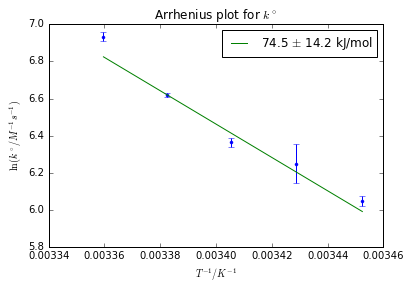

In [20]:
popt, pcov = np.polyfit(1/tempKs, logk0[:, 0], 1, w=logk0[:, 1]**-2, cov=True)
plt.errorbar(1/tempKs, logk0[:, 0], logk0[:, 1], marker='.', ls='None')
lbl = '{0:.1f} $\pm$ {1:.1f} kJ/mol'.format(popt[0]*-8.314511e-3, pcov[0,0]**0.5 * 8.314511e-3)
plt.plot(1/tempKs, np.polyval(popt, 1/tempKs), label=lbl)
plt.ylabel(r'$\ln(k^\circ / M^{-1} s^{-1})$')
plt.xlabel('$T^{-1}/K^{-1}$')
plt.title(r'Arrhenius plot for $k^\circ$')
plt.legend()

Vi kan också göra en ickelinjär anpassning av Arrhenius ekvation till kf mot T. Vi väljer jonstyrka 2 (med lägst osäkerhet)

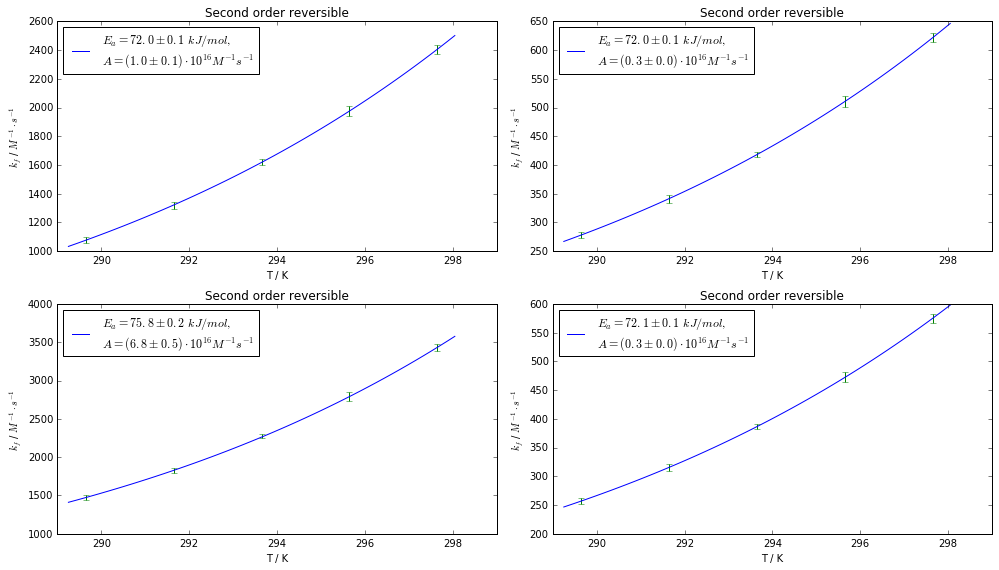

In [21]:
def Arrhenius(T, A, Ea):
    R = 8.314511
    return A*np.exp(-Ea/(R*T))

Tspan = tempKs[-1] - tempKs[0]
Tplot = np.linspace(tempKs[0] - 0.05*Tspan, tempKs[-1] + 0.05*Tspan)
fmtstr = ('$E_a={0:5.1f} \pm {1:5.1f}$ $kJ/mol,$\n$'
    'A=({2:5.1f} \pm {3:5.1f}) \cdot 10^{{16}} M^{{-1}} s^{{-1}}$')
plt.figure(figsize=(14,8))
for idxF, (funckey, func) in enumerate(funcs.items()):
    plt.subplot(2, 2, idxF + 1)
    idxI, idxT = 1, slice(None)
    kf_vals = pooled_fits[idxI, idxT, idxF, 0, 0]
    kf_errs = pooled_fits[idxI, idxT, idxF, 0, 1]
    #plt.errorbar(tempKs, kf_vals, kf_errs, marker='.', linestyle='None')
    Ea_guess, A_guess = 75e3, exp(35.5)
    #plt.plot(T, Arrhenius(T, A_guess, Ea_guess))
    popt, pcov = curve_fit(Arrhenius, tempKs, kf_vals, [A_guess, Ea_guess],  1/kf_errs)
    lbl = fmtstr.format(popt[1]/1e3, pcov[1,1]**0.5/1e3, popt[0]/1e16, pcov[0,0]**0.5/1e16)
    plt.plot(Tplot, Arrhenius(Tplot, *popt), label=lbl)
    plt.errorbar(tempKs,kf_vals, kf_errs**0.5, ls='None')
    plt.xlabel('T / K')
    plt.ylabel('$k_f$ / $M^{-1} \cdot s^{-1}$')
    plt.legend(loc='best')
    plt.title(funcs['binary_rev'].name)

plt.tight_layout()

En spännande biprodukt från analysen är fria energin för komplexbildning:

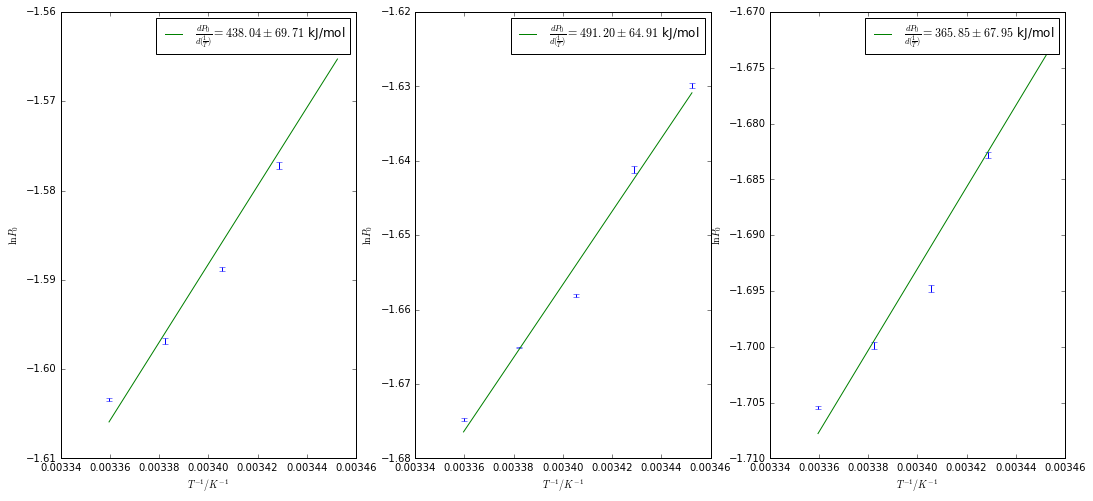

In [22]:
plt.figure(figsize=(18,8))
for idxI in range(1,4):
    plt.subplot(1, 3, idxI)
    idxT=slice(None); idxF=3; idxP=1
    logy = np.log(pooled_fits[idxI, idxT, idxF, idxP, 0])
    logy_u = pooled_fits[idxI, idxT, idxF, idxP, 0] + pooled_fits[idxI, idxT, idxF, idxP, 1]**0.5
    logy_l = pooled_fits[idxI, idxT, idxF, idxP, 0] - pooled_fits[idxI, idxT, idxF, idxP, 1]**0.5
    dlogy = 0.5*((logy_u - logy) + (logy - logy_l))
    plt.errorbar(1/tempKs, logy, dlogy, ls='None')
    popt, pcov = np.polyfit(1/tempKs, logy, 1, cov=True)
    lbl = r'$\frac{dP_0}{d(\frac{1}{T})}'+'={0:.2f} \pm {1:.2f}$ kJ/mol'.format(popt[0], pcov[0,0]**0.5)
    plt.plot(1/tempKs, np.polyval(popt, 1/tempKs), label=lbl)
    plt.xlabel('$T^{-1} / K^{-1}$')
    plt.ylabel('$\ln{P_0}$')
    plt.legend()
    